Load up experiment & annotations

In [2]:
import pandas as pd
import numpy as np
from data_reading.phyphox import read_experiment
from preprocessing._interpolation import align_data
from file_handling import get_sub_directories

experiment_dir_path = "../../data/phyphox/short recordings/"
experiment_dirs = get_sub_directories(experiment_dir_path)
offsets = {}
sample_rate = 50
chunks = {"right": [], "left": []}
y_columns = ["start", "end", "label", "hand"]
y = pd.DataFrame(columns=y_columns)
for dir in experiment_dirs:
    with open(dir + "/offset.txt") as f:
        for line in f:
           (key, val) = line.split(": ")
           offsets[key] = val

    data_frames = read_experiment(dir, offsets=offsets)
    data_frames = {key : align_data(data_frame, listening_rate=1000/sample_rate, reference_sensor=None) for key, data_frame in data_frames.items()}

    y_user = pd.read_csv(dir + "/annotations.tsv", delimiter="\t", header=None)
    hands = pd.read_csv(dir + "/hands.tsv", delimiter="\t", header=None)
    y_user = y_user.iloc[:, [3,5,8]]
    hands = hands.iloc[:, [8]]
    y_user = pd.concat([y_user, hands], axis=1)
    y_user.columns = y_columns
    y = pd.concat([y, y_user], axis=0)

    # iterate over the annotations and split the timeseries in chunks
    for key, df in data_frames.items():
        chunks[key] += [df.iloc[int(annotation["start"]*sample_rate):int(annotation["end"]*sample_rate)] for i, annotation in y.iterrows()]

/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_data_frame.py:31: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  time_delta_index = pd.TimedeltaIndex(timestamp_to_date, unit=output_timestamp_unit)


Preprocess data

In [3]:
# append the activity label (as int) and the action id to the dataframe
# we need to do this to be able to extract time series features later

labels = y.loc[:, "label"].unique()
label_ids = { l: i for l,i in zip(labels, range(0,len(labels))) }

# list of tuples (left chunk, right chunk)
chunks_two_handed = []
# list of chunks
chunks_one_handed = []

y = y.replace(label_ids)


for i, cl in zip(range(len(y)), y.iterrows()):
    label_id = int(cl[1]["label"])
    action_id = i
    two_handed_chunk = []
    for hand, chunk_list in chunks.items():
        c = chunk_list[i]
        chunk_hand = cl[1]["hand"]
        #if chunk_hand == "both":
        c["activity"] = label_id
        #else:
             # use an id that's not yet used for another activity to label "single handed" activities
        #    c["activity"] = len(y)
        c["activity"] = label_id
        c["action_id"] = action_id
        two_handed_chunk.append(c)
        if chunk_hand == hand:
            c["activity"] = label_id
            chunks_one_handed.append(c)
    left_chunk = two_handed_chunk[0].reset_index()
    right_chunk = two_handed_chunk[1].reset_index(drop=True)
    right_chunk.columns = [str(col) + '_right' for col in right_chunk.columns]
    two_handed_chunk = pd.concat([left_chunk, right_chunk], axis=1)
    two_handed_chunk.set_index('index', inplace=True)
    chunks_two_handed.append(two_handed_chunk)

/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

Feature extraction for 2 handed activities

In [4]:
%load_ext autoreload
%autoreload 2

labels = y.loc[:, "label"].squeeze()
from features._timeseries_feature_extraction import extract_timeseries_features
features_two_handed = extract_timeseries_features(pd.concat(chunks_two_handed).reset_index(drop=True))

Feature Extraction: 100%|██████████| 20/20 [06:23<00:00, 19.19s/it]


In [5]:

features_two_handed.replace([np.inf, -np.inf], np.nan, inplace=True)
features_two_handed.dropna(inplace=True, axis=1)
features_two_handed

variable,acceleration x__abs_energy,acceleration x__absolute_sum_of_changes,"acceleration x__agg_autocorrelation__f_agg_""mean""__maxlag_40","acceleration x__agg_autocorrelation__f_agg_""median""__maxlag_40","acceleration x__agg_autocorrelation__f_agg_""var""__maxlag_40","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""",...,linear_acceleration z_right__symmetry_looking__r_0.9500000000000001,linear_acceleration z_right__time_reversal_asymmetry_statistic__lag_1,linear_acceleration z_right__time_reversal_asymmetry_statistic__lag_2,linear_acceleration z_right__time_reversal_asymmetry_statistic__lag_3,linear_acceleration z_right__value_count__value_-1,linear_acceleration z_right__value_count__value_0,linear_acceleration z_right__value_count__value_1,linear_acceleration z_right__variance,linear_acceleration z_right__variance_larger_than_standard_deviation,linear_acceleration z_right__variation_coefficient
id,,,,,,,,,,,,,,,,,,,,,
0,152.362043,5.716829,-0.204547,-0.264752,0.160540,2.039521,1.603603,1.268438,0.074262,1.737264,...,1.0,347.499325,2077.840613,3161.051309,0.0,0.0,0.0,143.060915,1.0,-0.729506
1,5816.226167,69.420695,0.164614,0.180835,0.164279,6.047700,5.147875,3.815960,0.773449,5.708267,...,1.0,0.247599,0.896086,1.188017,0.0,0.0,0.0,2.627204,1.0,-4.796790
2,518.147057,30.058553,-0.088996,-0.161149,0.134872,3.086037,2.006977,1.123898,0.452958,2.804729,...,1.0,0.242447,0.334323,0.386098,0.0,0.0,0.0,0.828458,0.0,-2.411575
3,3387.762553,123.382555,-0.012698,-0.062500,0.057817,4.619957,2.207716,0.931568,2.584999,3.410621,...,1.0,-0.010524,-0.038137,-0.082098,0.0,0.0,0.0,1.140251,1.0,-9.194041
4,2835.841612,105.832075,0.222970,0.244265,0.035229,9.650999,5.708025,2.763782,4.055142,8.102911,...,1.0,0.054650,0.072999,0.080600,0.0,0.0,0.0,0.346956,0.0,5.285892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,1739.587649,25.253263,-0.005268,-0.200315,0.278574,1.759474,0.116994,-1.125396,1.205174,0.550021,...,1.0,0.000939,0.008686,0.017525,0.0,0.0,0.0,0.127271,0.0,-4.246347
195,1162.178751,2.668712,0.020474,-0.071871,0.056690,4.071664,3.999950,3.909313,0.004337,4.068603,...,1.0,0.000675,-0.004681,-0.007745,0.0,0.0,0.0,0.217131,0.0,-11.482384
196,1149.421534,2.204556,0.016768,0.000199,0.059931,4.223571,4.168416,4.111470,0.001302,4.203718,...,1.0,0.122694,0.383664,-0.273506,0.0,0.0,0.0,0.940875,0.0,-15.353622


TODO: Feature selection & visualization

Train models and score results

In [6]:
labels

0     0
1     1
2     0
3     1
4     0
     ..
63    9
64    6
65    9
66    6
67    9
Name: label, Length: 199, dtype: int64

Two handed classification
Logistic Regression 0.3517948717948718
LDA 0.9198717948717949
LinearSVC 0.33166666666666667
CART 1.0
NB 0.5480769230769231


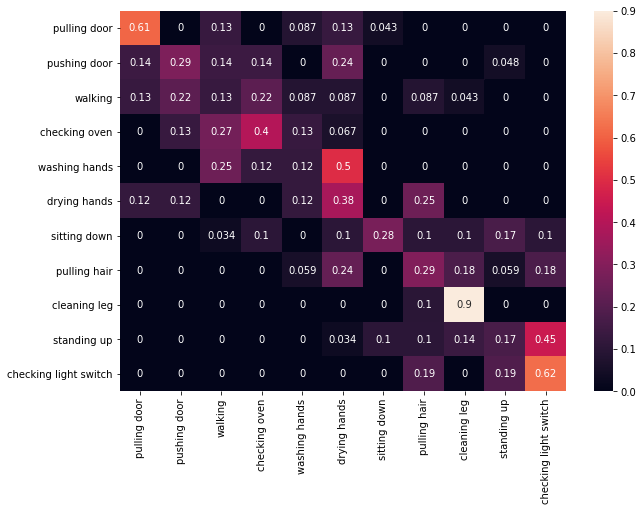

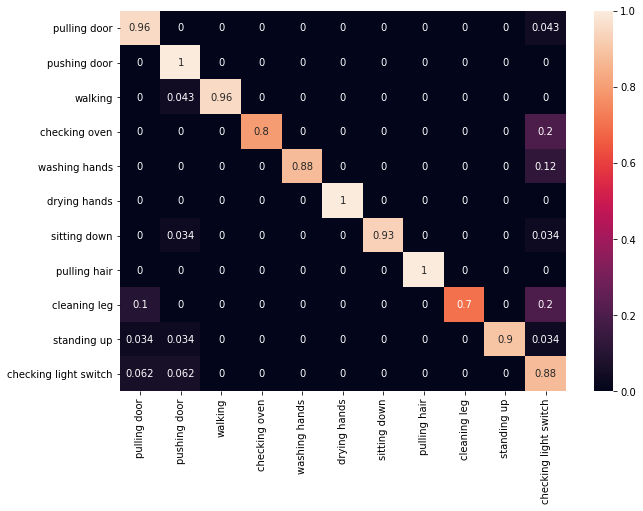

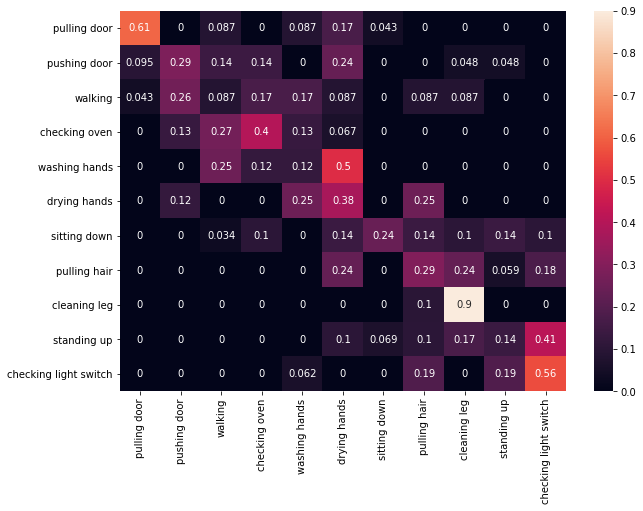

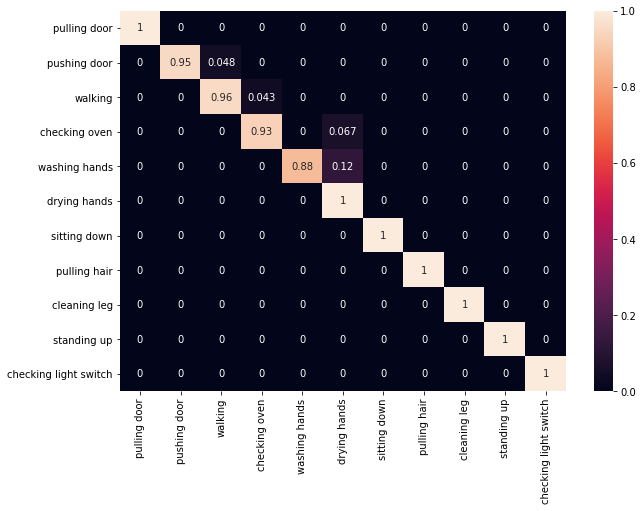

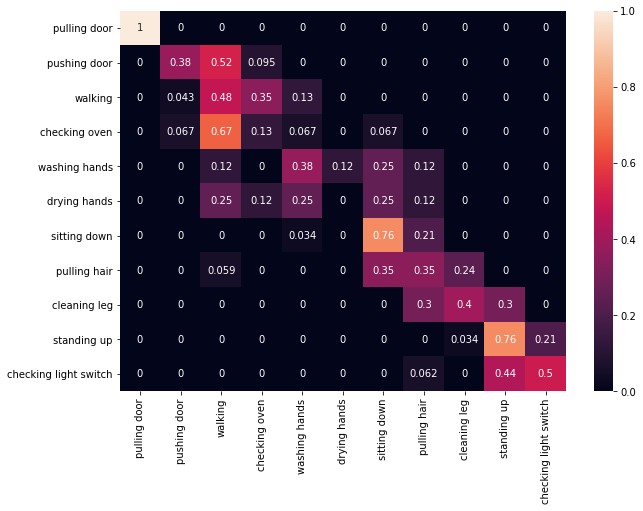

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

models = [('Logistic Regression', LogisticRegression(solver='liblinear', multi_class='ovr')), ('LDA', LinearDiscriminantAnalysis()), ('LinearSVC', LinearSVC()), ('CART', DecisionTreeClassifier()), ('NB', GaussianNB())]


def classify_all(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    for name, model in models:
        scores = cross_val_score(model, X_scaled, y, cv=5)
        print(name, scores.mean())

        # confusion matrix
        y_pred = cross_val_predict(model, X_scaled, y, cv=5)
        conf_mat = confusion_matrix(y, y_pred)
        #print(conf_mat)
        df_cm = pd.DataFrame(conf_mat, index = label_ids.keys(),
                  columns = label_ids.keys())
        df_cm["sum"] = df_cm.sum(axis=1)
        df_cm = df_cm.loc[:,label_ids.keys()].div(df_cm["sum"], axis=0)
        plt.figure(figsize = (10,7))
        sn.heatmap(df_cm, annot=True)
        plt.show()


print("Two handed classification")
classify_all(features_two_handed, labels)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_two_handed,labels, test_size=0.2)
m = models[0][1]
m.fit(X_train, y_train)
m.score(X_test, y_test)

/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.45

In [12]:
label_ids

{'pulling door': 0,
 'pushing door': 1,
 'walking': 2,
 'checking oven': 3,
 'washing hands': 4,
 'drying hands': 5,
 'sitting down': 6,
 'pulling hair': 7,
 'cleaning leg': 8,
 'standing up': 9,
 'checking light switch': 10}